# Hydraulic Connectivity

This notebook masks pixels that are not hydraulically connected to the ocean at 20m of SLR. This could be improved in future versions of SLIIDERS to calculate the height at which each pixel will flood from 0-20m.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import contextily as ctx
import geopandas as gpd
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
from dask_gateway import GatewayCluster
from rasterio import transform
from rasterio.features import shapes
from shapely.geometry import LineString, box, shape
from sliiders import settings as sset
from sliiders.dask import upload_sliiders
from sliiders.io import open_zarr, save, save_to_zarr_region
from sliiders.spatial import get_ll, get_tile_names

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
N_WORKERS = 200

# Fraction of cell to buffer geometries to ensure overlap w/ potential floating point
# precision issues
CELL_BUFFER = 0.75

TILES = pd.read_parquet(
    sset.PATH_EXPOSURE_TILE_LIST,
    filters=[("PROCESSING_SET", "in", ["CIAM", "WITHELEV"])],
).index.values

## Build template zarr

In [4]:
to_save = open_zarr(sset.PATH_ELEV_MSS)[["source"]].rename({"source": "connected"})
to_save.attrs = {}
to_save["connected"].attrs = {
    "long_name": "Hydraulic Connectivity Value",
    "description": (
        "Height at which this cell could be flooded. 201 indicates no flooding in "
        "first 20 meters. Units are in whole decimeters and the value corresponds to "
        "rounding down from the full-precision value"
    ),
    "units": "decimeters",
}

In [5]:
save(to_save, sset.PATH_ELEV_MSS, mode="a", compute=False)

## Build dataset of neighboring tiles

In [6]:
lls = [get_ll(t) for t in TILES]
lons = [i[0] for i in lls]
lats = [i[1] for i in lls]

base = pd.DataFrame({"lon": lons, "lat": lats}, index=TILES)


def adjust_base(E=0, N=0):
    out = base.copy()
    out["lon"] += E
    out["lon"] = out.lon.where(out.lon >= -180, 179).where(out.lon < 180, -180)
    out["lat"] += N
    above_pole = (out.lat > 90) | (out.lat < -90)
    out["lon"] = out.lon.where((~above_pole) | (out.lon < 0), out.lon - 180)
    out["lon"] = out.lon.where((~above_pole) | (out.lon >= 0), out.lon + 180)
    out["lat"] = out.lat.clip(lower=-90, upper=90)
    return out


W = get_tile_names(adjust_base(E=-1), "lon", "lat")
E = get_tile_names(adjust_base(E=1), "lon", "lat")
S = get_tile_names(adjust_base(N=-1), "lon", "lat")
N = get_tile_names(adjust_base(N=1), "lon", "lat")

neighbors = pd.DataFrame({"W": W, "E": E, "N": N, "S": S})
neighbors = neighbors.where(neighbors.isin(TILES))
isolated = neighbors.index[neighbors.isnull().all(axis=1)]
neighbors = neighbors.drop(isolated)

## Execute connectivity search

### Helper functions

In [7]:
def sel_tile(tile, path, invert_y=False):
    xmin, ymin = get_ll(tile)
    out = open_zarr(path, chunks=None).sel(
        lon=slice(xmin, xmin + 1 - 1e-10), lat=slice(ymin, ymin + 1 - 1e-10)
    )
    if invert_y and out.lat[-1] > out.lat[0]:
        out = out.sel(lat=out.lat.values[::-1])
    return out


def get_connected_polys(
    tile,
    connected_in=None,
    gdf_in=None,
    thresh=20,
    neighbor_dir=None,
    dx=0.75 / 3601,
    dy=0.75 / 3601,
):

    # if no connected polygons in neighbor, don't bother
    if neighbor_dir == "E" and not connected_in.connected_W.any():
        return gdf_in
    elif neighbor_dir == "W" and not connected_in.connected_E.any():
        return gdf_in
    elif neighbor_dir == "N" and not connected_in.connected_S.any():
        return gdf_in
    elif neighbor_dir == "S" and not connected_in.connected_N.any():
        return gdf_in

    xmin, ymin = get_ll(tile)
    coords = (xmin, ymin, xmin + 1, ymin + 1)
    tile_box = box(*coords)
    box_ext = tile_box.exterior
    Wbd = LineString([[xmin, ymin], [xmin, ymin + 1]])
    Ebd = LineString([[xmin + 1, ymin], [xmin + 1, ymin + 1]])
    Sbd = LineString([[xmin, ymin], [xmin + 1, ymin]])
    Nbd = LineString([[xmin, ymin + 1], [xmin + 1, ymin + 1]])
    bounds = {
        "W": Wbd.buffer(dx).intersection(tile_box),
        "E": Ebd.buffer(dx).intersection(tile_box),
        "S": Sbd.buffer(dy).intersection(tile_box),
        "N": Nbd.buffer(dy).intersection(tile_box),
    }

    if gdf_in is None:
        ds = sel_tile(tile, sset.PATH_ELEV_MSS, invert_y=True)

        assert ds.lon.size == ds.lat.size == 3601

        assert ds.z.notnull().all()

        # entirely ocean tile
        if (ds.source == 3).all():
            return gpd.GeoDataFrame(
                {
                    **{f"connected_{k}": [True] for k in "WESN"},
                    "geometry": [box(*coords)],
                },
                geometry="geometry",
            )

        tr = transform.from_bounds(
            *coords,
            ds.lon.size,
            ds.lat.size,
        )
        gdf = gpd.GeoSeries(
            [
                shape(s[0])
                for s in shapes(
                    (ds.z < thresh | (np.isclose(ds.z, thresh) & ds.int_res))
                    .astype("uint8")
                    .values,
                    mask=(ds.z <= thresh).values,
                    transform=tr,
                )
            ],
            name="geometry",
        ).explode(index_parts=False)

        # don't need to worry about any interior polygons since they cannot be
        # ocean-connected
        gdf = gdf[gdf.touches(box_ext)]
        gdf = gdf.to_frame().assign(
            connected_W=False, connected_E=False, connected_S=False, connected_N=False
        )
    else:
        gdf = gdf_in.copy()

    # now mark any connected tiles
    # if no connected poly provided, use ocean
    if connected_in is None:
        connected = gpd.read_parquet(sset.PATH_NATEARTH_OCEAN_NOCASPIAN).iloc[0, 0]
    # otherwise use neighbors polygons
    else:
        connected = connected_in.copy()
        assert neighbor_dir is not None

        if tile.endswith("W180") and neighbor_dir == "W":
            connected["geometry"] = connected.translate(xoff=-360)
        elif tile.endswith("E179") and neighbor_dir == "E":
            connected["geometry"] = connected.translate(xoff=360)

        # only evaluate those that are connected to the border we're looking at
        if neighbor_dir == "E":
            connected = connected[connected.connected_W].translate(xoff=-dx)
        elif neighbor_dir == "W":
            connected = connected[connected.connected_E].translate(xoff=dx)
        elif neighbor_dir == "N":
            connected = connected[connected.connected_S].translate(yoff=-dy)
        elif neighbor_dir == "S":
            connected = connected[connected.connected_N].translate(yoff=dy)
        connected = connected.geometry.intersection(tile_box)
        assert not connected.is_empty.any()
        connected = connected.unary_union

    if connected is not None:
        connected = gdf.geometry[
            gdf.filter(like="connected").any(axis=1) | gdf.intersects(connected)
        ]
        for b in "WSEN":
            gdf[f"connected_{b}"] = gdf[f"connected_{b}"] | connected.intersects(
                bounds[b]
            )

    return gdf


def final_filter(tile, polys, all_false=False, no_connect_val=201):
    ds = sel_tile(tile, sset.PATH_ELEV_MSS, invert_y=True)
    if all_false:
        out = xr.ones_like(ds.connected, dtype="bool") * no_connect_val
    else:
        polys = gpd.GeoSeries(
            [polys[polys.filter(like="connected").any(axis=1)].unary_union]
        )
        if polys[0] is None:
            out = xr.ones_like(ds.connected, dtype="bool") * no_connect_val
        else:
            # convert to decimeters
            out = np.maximum((ds.z * 10), 0).astype("uint8")
            out = out.where(
                regionmask.mask_geopandas(polys, out).notnull()
                & (out < no_connect_val),
                no_connect_val,
            )

    if out.lat[-1] < out.lat[0]:
        out = out.sel(lat=out.lat.values[::-1])

    # save this
    save_to_zarr_region(out.to_dataset(name="connected"), sset.PATH_ELEV_MSS)


def get_all_connected(fut):
    return fut.filter(like="connected").any(axis=1).all()


def get_none_connected(fut):
    return not fut.filter(like="connected").any().any()


def get_new_connections(df, neighbor_dir):
    if neighbor_dir == "E":
        bd = "W"
    elif neighbor_dir == "W":
        bd = "E"
    elif neighbor_dir == "N":
        bd = "S"
    elif neighbor_dir == "S":
        bd = "N"
    return df.index[df[f"connected_{bd}"]]


# which tiles still need edge polygons to be checked
def iterate(futs, new_connected=None, dx=0.75 / 3601, dy=0.75 / 3601):
    if new_connected is not None:
        remaining = new_connected.index
    else:
        remaining = futs.index

    print("Calculating number of connected polygons in each tile")
    n_connected_old = pd.DataFrame(
        client.gather(client.map(_get_n_connections, futs.loc[remaining].values)),
        index=remaining,
    )
    connections = pd.DataFrame(columns=["W", "E", "S", "N"])

    for direction in "WESN":
        print(f"Checking {direction} neighbors")

        # don't need to check neighbors for cells where all polys are already connected
        print("Checking which tiles are fully connected and can be skipped...")
        all_connected = np.array(
            client.gather(client.map(get_all_connected, futs.loc[remaining].values))
        )
        print("Number fully connected:", all_connected.sum())
        remaining = remaining[~all_connected]

        # filter to those that are not yet finished and have tile neighbors
        this_neighbors = neighbors.loc[remaining][direction].dropna()
        print("Number of tiles to check neighbors for:", len(this_neighbors))

        # filter to those with any new connections
        if new_connected is not None:
            print("...Filtering for new hydraulic connections in neighbors")
            new_connections = get_new_connections(new_connected, direction)

            # if no new connections along this boundary, move onto the next direction
            if not len(new_connections):
                "No new connections along this boundary. Skipping"
                continue

            # else filter the neighbors to only those with new connections
            this_neighbors = this_neighbors[this_neighbors.isin(new_connections)]

        # run the connected polys workflow
        print(f"Finding new connections for {len(this_neighbors)} neighbor pairs")
        futs.loc[this_neighbors.index] = client.map(
            get_connected_polys,
            this_neighbors.index,
            futs.loc[this_neighbors.values],
            futs.loc[this_neighbors.index],
            neighbor_dir=direction,
            dx=dx,
            dy=dy,
        )

        # track which tiles became connected
        n_connected_new = pd.DataFrame(
            client.gather(
                client.map(_get_n_connections, futs.loc[this_neighbors.index].values)
            ),
            index=this_neighbors.index,
        )[f"connected_{direction}"]
        connections[direction] = this_neighbors[
            n_connected_new
            > n_connected_old.loc[this_neighbors.index, f"connected_{direction}"]
        ]

    n_connected_new = pd.DataFrame(
        client.gather(client.map(_get_n_connections, futs.loc[remaining].values)),
        index=remaining,
    )
    new_connected = n_connected_new > n_connected_old.loc[remaining]

    if not new_connected.any().any():
        return futs, None, None

    connections = connections.rename_axis("tile")

    return futs, new_connected, connections


def _get_n_connections(gdf):
    return gdf.filter(like="connected").sum()

### Workflow execution

In [8]:
cluster = GatewayCluster(profile="micro", idle_timeout=1800)
client = cluster.get_client()
upload_sliiders(client)
cluster.scale(N_WORKERS)
cluster

In [9]:
with sel_tile(TILES[0], sset.PATH_ELEV_MSS) as ds:
    DX = CELL_BUFFER / ds.lon.size
    DY = CELL_BUFFER / ds.lat.size

#### Isolated Tiles
For tiles that don't have any neighbors, we can just look at ocean overlap and avoid any of the iteration

In [10]:
isolated_futs = pd.Series(
    client.map(get_connected_polys, isolated, dx=DX, dy=DY), index=isolated
)
isolated_futs = client.gather(
    client.map(final_filter, isolated_futs.index, isolated_futs.values)
)
del isolated_futs

#### Tiles with neighbors

In [11]:
futs = pd.Series(
    client.map(get_connected_polys, neighbors.index, dx=DX, dy=DY),
    index=neighbors.index,
)

##### Exclude no-boundary-connections tiles
For tiles that don't have any <20m area that touches the border, these are by definition going to be non-connected

In [12]:
non_connected = client.gather(client.map(get_none_connected, futs.values))
non_connected = futs.loc[non_connected]
futs = futs.drop(non_connected.index)

neighbors = neighbors.where(~neighbors.isin(non_connected.index))

# calculate final filter for non-connected tiles (should be False everywhere)
non_connected = client.gather(
    client.map(
        final_filter, non_connected.index, [None] * len(non_connected), all_false=True
    )
)
del non_connected

##### All the rest (tiles with neighbors and <20m pixels that touch the edge

In [13]:
connections = []

print("Iteration 1")
futs, new_connections, new_conn_tiles = iterate(futs, dx=DX, dy=DY)
connections.append(new_conn_tiles)
ix = 1
while new_connections is not None:
    ix += 1
    print("Iteration", ix)
    futs, new_connections, new_conn_tiles = iterate(
        futs, new_connected=new_connections, dx=DX, dy=DY
    )
    connections.append(new_conn_tiles)
print("Complete, beginning final raster burning")
final = client.gather(client.map(final_filter, futs.index, futs.values))

Iteration 1
Calculating number of connected polygons in each tile
Checking W neighbors
Checking which tiles are fully connected and can be skipped...
Number fully connected: 3310
Number of tiles to check neighbors for: 2558
Finding new connections for 2558 neighbor pairs
Checking E neighbors
Checking which tiles are fully connected and can be skipped...
Number fully connected: 250
Number of tiles to check neighbors for: 2374
Finding new connections for 2374 neighbor pairs
Checking S neighbors
Checking which tiles are fully connected and can be skipped...
Number fully connected: 313
Number of tiles to check neighbors for: 1964
Finding new connections for 1964 neighbor pairs
Checking N neighbors
Checking which tiles are fully connected and can be skipped...
Number fully connected: 184
Number of tiles to check neighbors for: 1902
Finding new connections for 1902 neighbor pairs
Iteration 2
Calculating number of connected polygons in each tile
Checking W neighbors
Checking which tiles are f

In [14]:
del final
cluster.close(), client.close()

(None, None)

## Save tile connection info for QA

In [15]:
all_connects = []
for this_conn in connections[:-1]:
    all_connects.append(
        this_conn.apply(lambda x: [i for i in x if isinstance(i, str)], axis=1)
    )
all_connects = pd.DataFrame(all_connects).T
all_connects.columns = "iter_" + (all_connects.columns + 1).astype(str)

In [16]:
save(all_connects, sset.PATH_HYDCON_TILE_CONNECTIONS)

## QA

In [17]:
all_connects.iter_4.dropna()

tile
N42W072    [N41W072]
Name: iter_4, dtype: object

In [18]:
ds = sel_tile("N42W072", sset.PATH_ELEV_MSS)
ds2 = sel_tile("N42W071", sset.PATH_ELEV_MSS)
ds = xr.concat((ds, ds2), dim="lon")

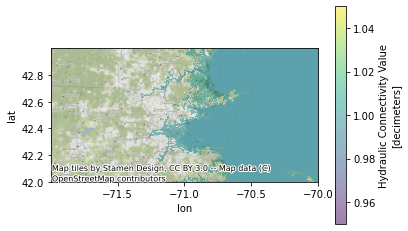

In [19]:
im = xr.ones_like(ds.connected).where(ds.connected != 201).plot(alpha=0.5)
ctx.add_basemap(im.axes, crs="EPSG:4327", cmap="Blues", vmax=1)

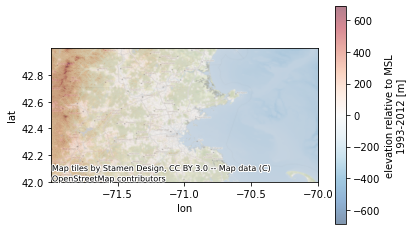

In [20]:
im = ds.z.plot(alpha=0.5)
ctx.add_basemap(im.axes, crs="EPSG:4327")